# Part 2 – Data Analytics

## Step 1: Crawl a real-world dataset

### Data source overview & Data collection
Register in TMDB and obtain an API Key, and comply with the terms of use.   
NOTICE: "This program uses TMDB and the TMDB APIs but is not endorsed, certified, or otherwise approved by TMDB."  
Access rate limit: 40 times/second   


- Dataset：The Movie Database (TMDB) Public API, movie resource entry point: https://www.themoviedb.org/movie
- Call the Discover Movies API: https://api.themoviedb.org/3/discover/movie
- Data type: Movie metadata:
  - The Discover movies API metadata types include: id, title, release_date, vote_average, vote_count, popularity, original_language, genre_ids, overview ect.
  - For more details, please refer to the official documentation:https://developer.themoviedb.org/reference/discover-movie
- Data extraction scale: 200 movie records were extracted page by page, due to the release year


In [203]:
import requests
import pandas as pd


def fetch_tmdb_movies(api_key="7f8c6e28203eb7d6a49fa0caf4466396", start_date="2020-01-01", end_date="2025-12-31", max_results=3000, language="en-UK"):
    """Fetch popular movies from TMDB discover API within a date range."""
    api_key = api_key
    base_url = "https://api.themoviedb.org/3/discover/movie"
    params = {
        "api_key": api_key,
        "language": language,
        "primary_release_date.gte": start_date,
        "primary_release_date.lte": end_date,
        "page": 1,
    }

    records = []
    while len(records) < max_results:
        result = requests.get(base_url, params=params, timeout=10)
        result.raise_for_status()
        data = result.json()
        for movie in data.get("results", []):
            records.append({
                "id": movie.get("id"),
                "title": movie.get("title"),
                "release_date": movie.get("release_date"),
                "vote_average": movie.get("vote_average"),
                "vote_count": movie.get("vote_count"),
                "popularity": movie.get("popularity"),
                "original_language": movie.get("original_language"),
                "genre_ids": movie.get("genre_ids"),
            })
            if len(records) >= max_results:
                break
        if not data.get("total_pages"): 
            break
        elif params["page"] >= data.get("total_pages", 0):
            break
        params["page"] += 1
    movie_data = pd.DataFrame(records)
    return movie_data


### Variables and schema
- `id`: The movie's unique ID
- `title`: Movie title
- `release_date`: Release date
- `vote_average`: TMDB average rating
- `vote_count`: The number of people who voted
- `popularity`: Popularity index
- `original_language`: Original language code
- `genre_ids`: List of type IDs.


In [204]:
df_movies = fetch_tmdb_movies(start_date="2020-01-01", end_date="2025-12-31", max_results=3000)
display(df_movies.head())

,id,title,release_date,vote_average,vote_count,popularity,original_language,genre_ids
0,1062722,Frankenstein,2025-10-17,7.796,1559,485.1768,en,"[18, 27, 14]"
1,1054867,One Battle After Another,2025-09-23,7.500,1481,415.1173,en,"[28, 53, 80]"
2,1248226,Playdate,2025-11-05,6.301,214,309.1327,en,"[28, 35, 10751]"
3,1116465,A Legend,2024-07-05,6.600,79,356.6402,zh,"[28, 12, 14]"
4,1419406,The Shadow's Edge,2025-08-16,6.400,66,487.4401,zh,"[28, 80, 53]"


### Secondary data crawling & Table merging

It's clear that first attempt at scraping data via an API yielded basic information about the films.  
However, based on evaluation, I believe I need more detailed data for each film to improve analysis:
 - `runtime`: Video length 
 - `budget`: Film cost/budget 
 - `revenue`: Box office revenue 
 - `status`: Release status 
 - `original_title`: Original language title 
 - `tagline`: Marketing tagline 
 - `spoken_languages`: Spoken languages list 
 - `production_countries`: Production countries 

I merge the two tables using the movie's unique ID.


In [205]:
import time

def fetch_movie_detail(movie_id, api_key="7f8c6e28203eb7d6a49fa0caf4466396"):
    url = f"https://api.themoviedb.org/3/movie/{movie_id}"
    resp = requests.get(url, params={"api_key": api_key}, timeout=10)
    resp.raise_for_status()
    details = resp.json()

    spoken_lang_names = ", ".join(
        sorted(
            {
                lang.get("english_name") or lang.get("name")
                for lang in (details.get("spoken_languages") or [])
                if lang.get("english_name") or lang.get("name")
            }
        )
    )
    production_country_codes = ", ".join(
        sorted(
            {
                country.get("iso_3166_1") or country.get("name")
                for country in (details.get("production_countries") or [])
                if country.get("iso_3166_1") or country.get("name")
            }
        )
    )

    return {
        "id": movie_id,
        "runtime": details.get("runtime"),
        "budget": details.get("budget"),
        "revenue": details.get("revenue"),
        "status": details.get("status"),
        "original_title": details.get("original_title"),
        "tagline": details.get("tagline"),
        "spoken_languages": spoken_lang_names,
        "production_countries": production_country_codes,
    }

detail_record = []
for movie_id in df_movies["id"]:
    detail_record.append(fetch_movie_detail(movie_id))
    time.sleep(0.1)  # add a sleep time to control access frequency

df_movie_details = pd.DataFrame(detail_record)

display(df_movie_details.head())

"""merge the two tables with unique ID"""
df_movie_full = df_movies.merge(df_movie_details, on = "id", how = "left")
display(df_movie_full.head())


,id,runtime,budget,revenue,status,original_title,tagline,spoken_languages,production_countries
0,1062722,152,120000000,144496,Released,Frankenstein,Only monsters play God.,"Danish, English, French","CA, US"
1,1054867,162,130000000,200300000,Released,One Battle After Another,"Some search for battle, others are born into i...","English, Spanish, Telugu",US
2,1248226,95,0,0,Released,Playdate,Playtime just got real.,English,"CA, US"
3,1116465,129,0,11242056,Released,传说,,"English, Mandarin","CN, HK"
4,1419406,142,0,702538,Released,捕风追影,,Mandarin,"CN, HK"


,id,title,release_date,vote_average,vote_count,popularity,original_language,genre_ids,runtime,budget,revenue,status,original_title,tagline,spoken_languages,production_countries
0,1062722,Frankenstein,2025-10-17,7.796,1559,485.1768,en,"[18, 27, 14]",152,120000000,144496,Released,Frankenstein,Only monsters play God.,"Danish, English, French","CA, US"
1,1054867,One Battle After Another,2025-09-23,7.500,1481,415.1173,en,"[28, 53, 80]",162,130000000,200300000,Released,One Battle After Another,"Some search for battle, others are born into i...","English, Spanish, Telugu",US
2,1248226,Playdate,2025-11-05,6.301,214,309.1327,en,"[28, 35, 10751]",95,0,0,Released,Playdate,Playtime just got real.,English,"CA, US"
3,1116465,A Legend,2024-07-05,6.600,79,356.6402,zh,"[28, 12, 14]",129,0,11242056,Released,传说,,"English, Mandarin","CN, HK"
4,1419406,The Shadow's Edge,2025-08-16,6.400,66,487.4401,zh,"[28, 80, 53]",142,0,702538,Released,捕风追影,,Mandarin,"CN, HK"


Create a CSV file with descriptions for each column element.

In [206]:
column_descriptions = {
    "id": "Unique movie ID",
    "title": "Localized title returned by API",
    "release_date": "Release date (YYYY-MM-DD)",
    "vote_average": "TMDB average rating",
    "vote_count": "Number of votes submitted",
    "popularity": "Popularity index (TMDB metric)",
    "original_language": "Original language ISO code",
    "genre_ids": "List of TMDB genre IDs",
    "runtime": "Runtime in minutes",
    "budget": "Production budget in USD",
    "revenue": "Box office revenue in USD ",
    "status": "Release status flag",
    "original_title": "Original language title",
    "tagline": "Marketing tagline",
    "spoken_languages": "Comma-separated spoken languages",
    "production_countries": "Comma-separated production countries or ISO codes"
}

schema_records = [
    {"column": col, "description": column_descriptions[col]}
    for col in df_movie_full.columns
]

schema_df = pd.DataFrame(schema_records)


### Storage as CSV
- Storage path：local



In [340]:
from pathlib import Path

output_path = Path("C:\\Users\\10525\\Desktop\\SDPA-final\\SDPA_EMATM0048_2720314\\data\\tmdb_movies_2020-2025.csv")
output_path.parent.mkdir(parents=True,exist_ok=True)
df_movie_full.to_csv(output_path)

schema_path = Path("C:/Users/10525/Desktop/SDPA-final/SDPA_EMATM0048_2720314/data/movie_schema.csv")
schema_path.parent.mkdir(parents=True, exist_ok=True)
schema_df.to_csv(schema_path, index=False)


## Step 2: Perform data preparation and cleaning 

### Load data
- Explains the parameters for using `pandas.read_csv` to read CSV files.
- Record the initial DataFrame shape and data type checks.

In [672]:
movie_data = pd.read_csv("C:\\Users\\10525\\Desktop\\SDPA-final\\SDPA_EMATM0048_2720314\\data\\tmdb_movies_2020-2025.csv")
movie_data.drop(columns=["Unnamed: 0"], inplace = True)
movie_schema = pd.read_csv("C:/Users/10525/Desktop/SDPA-final/SDPA_EMATM0048_2720314/data/movie_schema.csv")

In [673]:
data_shape = movie_data.shape
print(f"initial data shape: {data_shape[0]} rows, {data_shape[1]} columns")

initial data shape: 3016 rows, 16 columns


In [674]:
movie_data.dtypes

id                        int64
title                    object
release_date             object
vote_average            float64
vote_count                int64
popularity              float64
original_language        object
genre_ids                object
runtime                   int64
budget                    int64
revenue                   int64
status                   object
original_title           object
tagline                  object
spoken_languages         object
production_countries     object
dtype: object

In [675]:
movie_data.describe()

,id,vote_average,vote_count,popularity,runtime,budget,revenue
count,3.016000e+03,3016.000000,3016.000000,3016.000000,3016.000000,3.016000e+03,3.016000e+03
mean,9.966702e+05,5.146490,495.829244,10.507266,90.956897,1.118004e+07,2.736155e+07
std,2.835792e+05,2.625124,1458.473250,22.728376,37.419279,3.904572e+07,1.316168e+08
min,1.349400e+04,0.000000,0.000000,3.540600,0.000000,0.000000e+00,0.000000e+00
25%,7.746482e+05,4.426000,2.000000,5.991500,84.000000,0.000000e+00,0.000000e+00
50%,1.004866e+06,6.009500,17.000000,6.735550,96.000000,0.000000e+00,0.000000e+00
75%,1.223265e+06,6.900000,180.000000,8.466475,109.000000,0.000000e+00,0.000000e+00
max,1.580234e+06,10.000000,21280.000000,487.440100,604.000000,5.839000e+08,2.330225e+09


The extracted data contains null values, and some data is unreasonable  
Therefore, "Missing values & Outliers" will be to preprocess the data to make it as compatible with our requirements as possible.

### Missing values & Outliers
- Describe the methods and strategies for detecting missing values ​​(deletion/filling/interpolation), and explain the reasons for choosing them.
- Describe the rules or statistical methods for detecting outliers/inconsistent data, and the corrective/filtering measures and their basis.

Clearly, `vote_average`, `vote_count`, `budget`, `revenue`, and `runtime` cannot be 0. The only possible reasons are the lack of audience ratings, undisclosed budgets, revenues, and runtime.  
Therefore, we convert the 0 values ​​in these columns to **NaN** values.

In [676]:
"""Convert unreasonable 0 values ​​to NaN"""
conversion_list = [
    "vote_average",
    "vote_count",
    "budget",
    "revenue",
    "runtime"
]
movie_data[conversion_list] = movie_data[conversion_list].replace(0, pd.NA)

In [677]:
"""Calculate the number of missing values ​​and the missing rate."""
def missing_report():
    miss_report = pd.DataFrame({
        "missing_count": movie_data.isna().sum(),
        "missing_pct": movie_data.isna().mean().round(3)
        })
    return miss_report

display(missing_report())

,missing_count,missing_pct
id,0,0.000
title,0,0.000
release_date,0,0.000
vote_average,496,0.164
vote_count,494,0.164
popularity,0,0.000
original_language,0,0.000
genre_ids,0,0.000
runtime,147,0.049
budget,2323,0.770


`Revenue` and `budget` will be important data for subsequent calculations. They are crucial features for evaluating a film's success, so we have removed all movies with empty columns from the statistics.   

In [678]:
"""remove movies with empty value in budget and revenue"""
movie_data = movie_data.loc[~movie_data["budget"].isnull()]
movie_data = movie_data.loc[~movie_data["revenue"].isnull()]


"""dtype conversion"""
for col in ["budget", "revenue", "vote_average", "vote_count", "runtime"]:
    movie_data[col] = pd.to_numeric(movie_data[col], errors="coerce")
    
movie_data.shape

(499, 16)

In [679]:
"""remove movies with empty value in "genre_ids"(doubel check "genre_ids" is not empty list) """
def valid_genres(value):
    if pd.isna(value):
        return False
    if isinstance(value, str):
        stripped = value.strip()
        return bool(stripped and stripped != "[]")
    try:
        return len(value) > 0
    except TypeError:
        return False

movie_data = movie_data[movie_data["genre_ids"].apply(valid_genres)]
movie_data.shape

(499, 16)

For null values ​​in features: `tagline`, `spoken_languages` and `production_countries`, format normalization will be performed to preserve data integrity to the greatest extent possible.

In [680]:
"""normalization in formatting terms"""
text_fill_cols = ["tagline", "spoken_languages", "production_countries"]
for col in text_fill_cols:
    movie_data[col] = movie_data[col].fillna("Unknown")

def normalize_multivalue_field(value):
    if value is pd.NA or value is None or value == "Unknown":
        return ["Unknown"]
    if isinstance(value, list):
        cleaned = [str(item).strip() for item in value if str(item).strip()]
        return cleaned or ["Unknown"]
    parts = [item.strip() for item in str(value).split(",") if item.strip()]
    return parts or ["Unknown"]

movie_data["spoken_languages"] = movie_data["spoken_languages"].apply(normalize_multivalue_field)
movie_data["production_countries"] = movie_data["production_countries"].apply(normalize_multivalue_field)

display(movie_data[["tagline", "spoken_languages", "production_countries"]].head())
display(missing_report())

,tagline,spoken_languages,production_countries
0,Only monsters play God.,"[Danish, English, French]","[CA, US]"
1,"Some search for battle, others are born into i...","[English, Spanish, Telugu]",[US]
6,Fight for justice.,"[Cantonese, English, Japanese, Mandarin]","[CN, HK]"
7,First hunt. Last chance.,[English],[US]
12,Unlock the illusion.,[English],"[AU, US]"


,missing_count,missing_pct
id,0,0.0
title,0,0.0
release_date,0,0.0
vote_average,0,0.0
vote_count,0,0.0
popularity,0,0.0
original_language,0,0.0
genre_ids,0,0.0
runtime,0,0.0
budget,0,0.0


### Feature engineering
record newly added or transformed features :
 - date parsing
 - category coding
 - normalization/standardization
 - binning

Having completed the processing of all 0 and null values  
proceed with outlier identification and handling

In [681]:
def remove_outliers(feature, lower, upper, data_frame = movie_data):
    before = len(data_frame)
    filtered = data_frame[data_frame[feature].between(lower, upper, inclusive="both")].copy()
    removed = before - len(filtered)

    print(f"Removed {removed} rows with {feature} outside [{lower}, {upper}]")
    return filtered

In [682]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_box_with_points(series, title, xlabel):
    """Box plot & Data distribution"""
    cleaned = series.dropna()
    fig, ax = plt.subplots(figsize=(6, 3.5))
    sns.boxplot(x=cleaned, ax=ax, color ="white", fliersize=0)
    sns.stripplot(x=cleaned, ax=ax, color="green", alpha=0.45, size=3, jitter=0.15)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    plt.show()


def plot_dual_box_with_points(main_series, cold_series, xlabel, suptitle):
    """Box plot & Data distribution for both main_series & cold_series"""
    if cold_series is not None:
        main_cleaned = main_series.dropna()
        cold_cleaned = cold_series.dropna() 
    else:
        main_cleaned = main_series.dropna()
        cold_cleaned = pd.Series(dtype=float)

    fig, axes = plt.subplots(1, 2, figsize=(12, 3.5), sharex=False) 
    """Due to the characteristics of cold_movie data, the x-axis needs to be scaled."""
    datasets = [
        ("Main dataset", main_cleaned),
        ("Cold movies", cold_cleaned),
    ]

    for ax, (subtitle, values) in zip(axes, datasets):
        if values.empty:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=10)
            ax.set_xlabel(xlabel)
            ax.set_title(subtitle)
            ax.set_yticks([])
            continue
        sns.boxplot(x=values, ax=ax, color="white", fliersize=0)
        sns.stripplot(x=values, ax=ax, color="green", alpha=0.45, size=3, jitter=0.15)
        ax.set_xlabel(xlabel)
        ax.set_title(subtitle)

    """x-axis scaled five times"""
    main_min, main_max = main_cleaned.min(), main_cleaned.max()
    span = main_max - main_min
    cold_axis = axes[1]
    cold_min = cold_cleaned.min()
    cold_max = cold_cleaned.max()
    desired_span = span / 5
    cold_max = min(cold_max, cold_min + desired_span)
    cold_axis.set_xlim(cold_min, cold_max)

    fig.suptitle(suptitle)
    plt.tight_layout()
    plt.show()


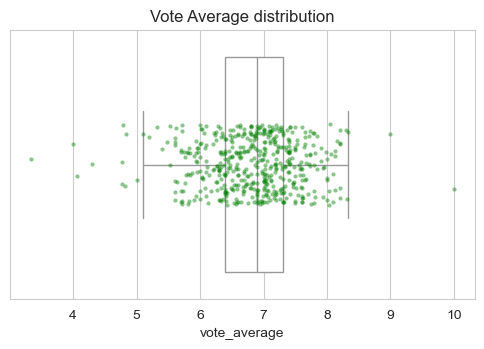

In [683]:
with pd.option_context("display.float_format", "{:.2f}".format):
    plot_box_with_points(movie_data["vote_average"], "Vote Average distribution", "vote_average")

`vote_average`: observing the distribution plot, we can see that there are a very small number of extreme data points  
The rule states that values ​​with `vote_average` less than 4.5 or greater than 9.5 are considered as extreme outliers and will be removed.

In [684]:
movie_data = remove_outliers(feature = "vote_average", lower = 4.5, upper = 9.5)

Removed 5 rows with vote_average outside [4.5, 9.5]


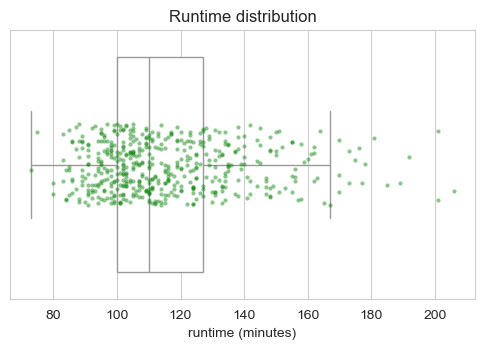

In [685]:
with pd.option_context("display.float_format", "{:.2f}".format):
    plot_box_with_points(movie_data["runtime"], "Runtime distribution", "runtime (minutes)")

`runtime`: Similar to `vote_average`, outlier identification is performed based on the common movie duration [60, 200].

In [686]:
movie_data = remove_outliers(feature = "runtime", lower = 60, upper = 200)

Removed 4 rows with runtime outside [60, 200]


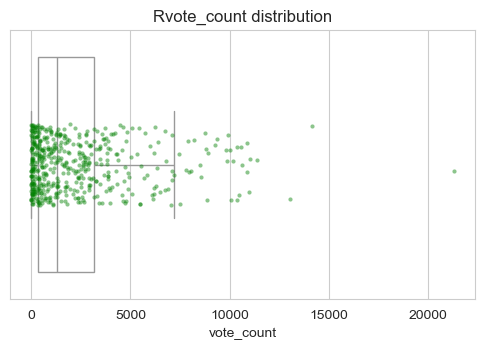

In [687]:
with pd.option_context("display.float_format", "{:.2f}".format):
    plot_box_with_points(movie_data["vote_count"], "Rvote_count distribution", "vote_count")


`vote_count`: The data is naturally "long-tailed," with some movies receiving only a few votes while others have hundreds of thousands, reflecting the films' popularity. Directly deleting high or low votes would result in the loss of crucial information. Therefore, we store excessively unpopular films (`vote_count` < 50) in a separate DataFrame: cold_movies for subsequent classification and analysis.

`vote_count_log`: the log transformation of `vote_count` is used in subsequent analysis/modeling to control the impact of extreme values.

In [688]:
import numpy as np

"""category the movies by vote_count"""
min_votes = 50
cold_movies = movie_data[movie_data["vote_count"] < min_votes].copy()
movie_data = movie_data[movie_data["vote_count"] >= min_votes].copy()

print(f"Identified {len(cold_movies)} low-vote movies (< {min_votes} ratings) for separate analysis.")
print(f"Remaining dataset rows: {len(movie_data)}")

"""creat column "vote_count_log" to control the impact of extreme values"""
movie_data["vote_count_log"] = np.log1p(movie_data["vote_count"])


Identified 39 low-vote movies (< 50 ratings) for separate analysis.
Remaining dataset rows: 456


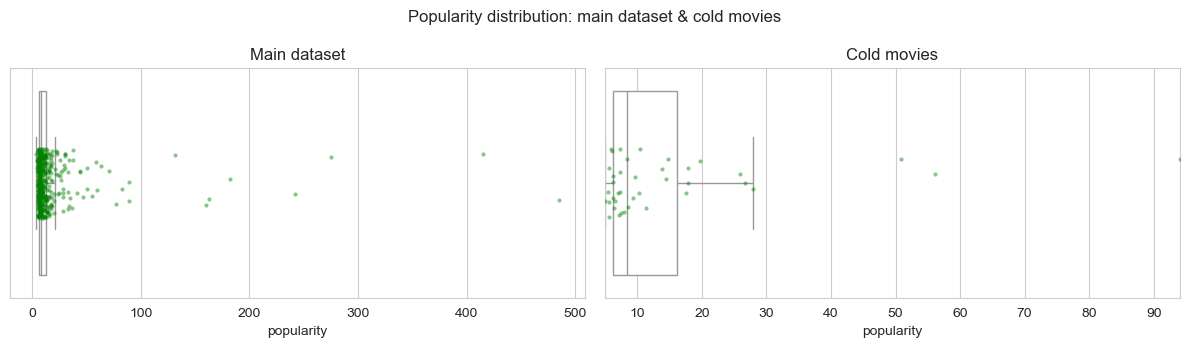

In [689]:
cold_series = cold_movies["popularity"]
plot_dual_box_with_points(
    movie_data["popularity"],
    cold_series,
    "popularity",
    "Popularity distribution: main dataset & cold movies"
)

`popularity`: Calculate the 99% quantile of popularity, removing the top 1% movies to prevent them from dominating the statistics.
`popularity_log`:  the log transformation of `popularity` is used in subsequent analysis/modeling to convenient regression/visualization

Tips: The data in **cold_movie** has a "smoother long tail" compared to **main_data**, so it doesn't need to be truncated.

In [690]:
pop_clip = 0.99
popularity_cap = movie_data["popularity"].quantile(pop_clip)
movie_data["popularity_clipped"] = movie_data["popularity"].clip(upper=popularity_cap)
movie_data["popularity_log"] = np.log1p(movie_data["popularity_clipped"])

print(f"Popularity values above the {pop_clip:.0%} quantile ({popularity_cap}) were clipped.")

Popularity values above the 99% quantile (171.3398249999998) were clipped.


After processing, we can visualize the main movie_data using `popularity_log` as follow.

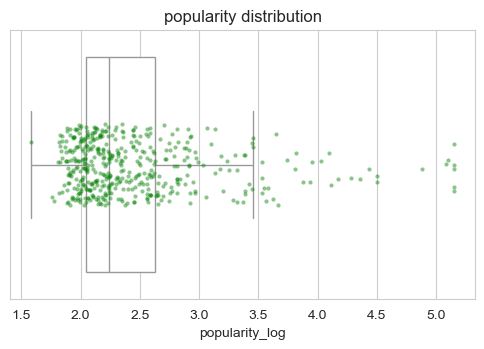

In [691]:
with pd.option_context("display.float_format", "{:.2f}".format):
    plot_box_with_points(movie_data["popularity_log"], "popularity distribution", "popularity_log")

Budget distribution & Revenue distribution for both main and cold movies as below

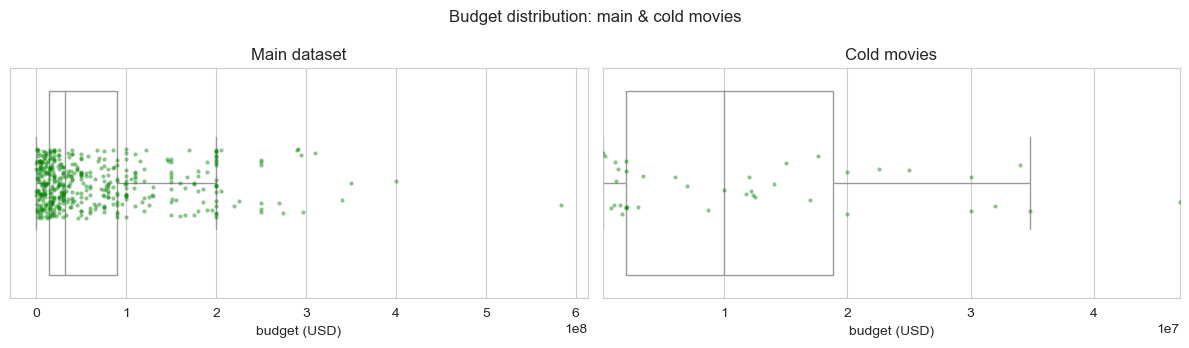

In [692]:
cold_series = cold_movies["budget"]
plot_dual_box_with_points(
    movie_data["budget"],
    cold_series,
    "budget (USD)",
    "Budget distribution: main & cold movies"
)

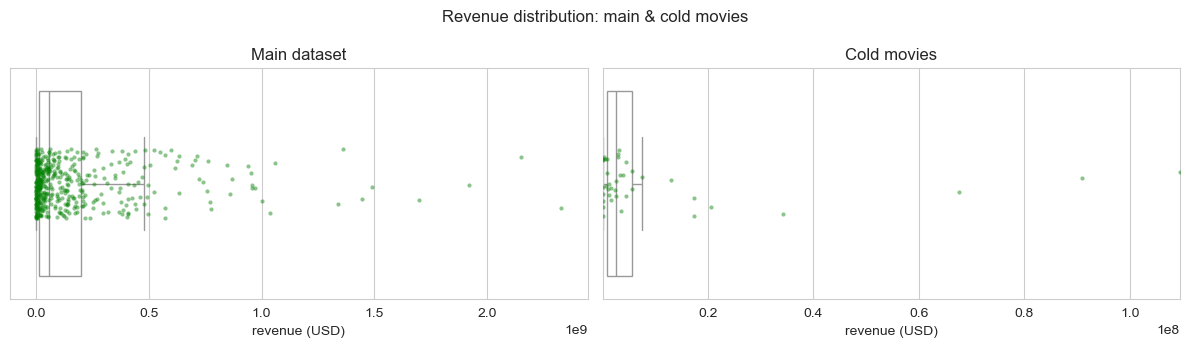

In [693]:
cold_series = cold_movies["revenue"]
plot_dual_box_with_points(
    movie_data["revenue"],
    cold_series,
    "revenue (USD)",
    "Revenue distribution: main & cold movies"
)

In [694]:
movie_data = remove_outliers(feature = "revenue", lower = 10000, upper = np.inf)

Removed 11 rows with revenue outside [10000, inf]


**main dataset**: The `revenue` and `budget` in the main dataset still exhibit a "long tail effect," but especially their coupling, we use the derived metric `ROI` for optimization.
 - tips :`ROI`= `revenue` / `budget`,  `ROI` allows for a more direct comparison of the films' economic performance.


**cold movies**: compared to the **main dataset**, the spans for both `budget` and `revenue` are shapely reduced, the box plots saw most of the scaled horizontal axis, and there are fewer outliers, making them suitable for independent analysis.

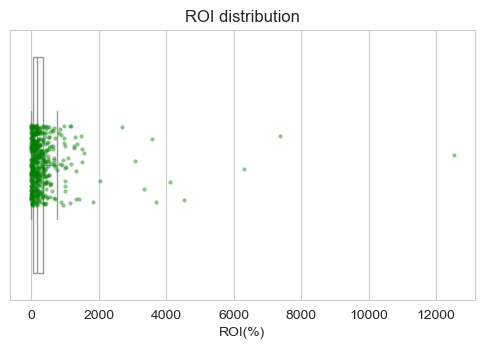

In [695]:
"""ROI = revenue / budget"""
movie_data["ROI"] = movie_data["revenue"] / movie_data["budget"]

with pd.option_context("display.float_format", "{:.4f}".format):
    plot_box_with_points(movie_data["ROI"] * 100, "ROI distribution", "ROI(%)")

Normally, the `ROI` will not exceed 2000%.   
However, to avoid the emergence of ultra-low-budget films that unexpectedly become hits, we added a column `ROI_flag` to distinguish whether their `ROI` is over 2000%, so as to facilitate subsequent classification and analysis. - (binning)

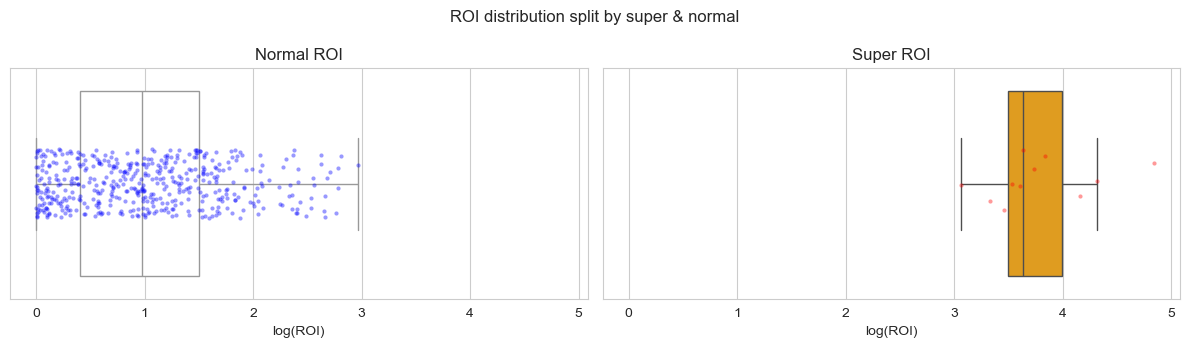

In [696]:
roi_max = 20
movie_data["ROI_log"] = np.log1p(movie_data["ROI"])
movie_data["ROI_flag"] = np.where(movie_data["ROI"] > roi_max, "super_ROI", "normal_ROI")

super_ROI = movie_data.loc[movie_data["ROI_flag"] == "super_ROI"]["ROI_log"]
normal_ROI = movie_data.loc[movie_data["ROI_flag"] == "normal_ROI"]["ROI_log"]

fig, axes = plt.subplots(1, 2, figsize=(12, 3.5), sharex=True)
sns.boxplot(x=normal_ROI, ax=axes[0], color="white", fliersize=0)
sns.stripplot(x=normal_ROI, ax=axes[0], color="blue", alpha=0.4, size=3, jitter=0.15)
axes[0].set_title("Normal ROI")
axes[0].set_xlabel("log(ROI)")

sns.boxplot(x=super_ROI, ax=axes[1], color="orange", fliersize=0)
sns.stripplot(x=super_ROI, ax=axes[1], color="red", alpha=0.4, size=3, jitter=0.15)
axes[1].set_title("Super ROI")
axes[1].set_xlabel("log(ROI)")

fig.suptitle("ROI distribution split by super & normal")
plt.tight_layout()
plt.show()

After binning by "super_ROI" and "normal_ROI", the distribution is relatively uniform and concentrated, making it suitable as an independent analysis.

In [703]:
movie_data["vote_count_log"] = np.log1p(movie_data["vote_count"])
movie_data["popularity_log"] = np.log1p(movie_data["popularity"])
with pd.option_context("display.float_format", "{:.2f}".format):
    display(movie_data.describe())

,id,vote_average,vote_count,popularity,runtime,budget,revenue,ROI,ROI_log,vote_count_log,popularity_log
count,488.00,488.00,488.00,488.00,488.00,488.00,488.00,488.00,488.00,488.00,488.00
mean,815579.35,6.83,2351.65,16.60,115.65,61741947.50,164110786.68,3.63,1.07,6.84,2.47
std,276832.95,0.72,2790.74,36.71,22.51,74479327.65,290131762.53,8.59,0.81,1.71,0.66
min,38700.00,3.34,2.00,3.87,73.00,15000.00,10647.00,0.00,0.00,1.10,1.58
25%,590585.25,6.40,379.00,6.74,99.75,12150000.00,9035612.75,0.53,0.42,5.94,2.05
50%,799821.00,6.90,1334.50,8.41,110.00,30000000.00,50610000.00,1.68,0.99,7.20,2.24
75%,1050672.75,7.30,3265.00,13.24,127.25,85250000.00,181772515.50,3.64,1.53,8.09,2.66
max,1422096.00,9.00,21280.00,485.18,206.00,583900000.00,2330224914.00,125.29,4.84,9.97,6.19
